<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
<li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-2">Prerequisites</a></span></li>
<li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li>
<li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-4">Data preparation</a></span></li>
<li><span><a href="#SequenceToSequence-model" data-toc-modified-id="SequenceToSequence-model-5">SequenceToSequence model</a></span></li>
<ul class="toc-item">
<li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-5.1">Load model architecture</a></span></li>
<li><span><a href="#Model-training" data-toc-modified-id="Model-training-5.2">Model training</a></span></li>    
<li><span><a href="#Validate-results" data-toc-modified-id="Validate-results-5.3">Validate results</a></span></li>
<li><span><a href="#Model-metrics" data-toc-modified-id="Model-metrics-5.4">Model metrics</a></span></li>    
<li><span><a href="#Saving-the-trained-model" data-toc-modified-id="Saving-the-trained-model-5.5">Saving the trained model</a></span></li>
</ul>
<li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-6">Model inference</a></span></li>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li>
<li><span><a href="#References" data-toc-modified-id="References-8">References</a></span></li>
</ul></div>

# Introduction

**Address Standardization** is the process of changing addresses to adhere to USPS standards. In this notebook, we will aim at abbreviating the addresses as per standard USPS abbreviations. 

**Address Correction** will aim at correcting  miss-spelled place names.

We will train a model using `SequenceToSequence` class of `arcgis.learn.text` module to translate the non-standard and erroneous address to their standard and correct form. 

The dataset consists of a pair of non-standard, incorrect(synthetic errors) house addresses and corresponding correct, standard house addresses from the United States. The correct addresses are taken from [OpenAddresses data](http://results.openaddresses.io/).

*Disclaimer: The correct addresses were synthetically corrupted to prepare the training dataset, this could have lead to some unexpected corruptions in addresses, which will affect the translation learned by the model.* 

**A note on the dataset**
- The data is collected around 2020-04-30 by [OpenAddresses](http://openaddresses.io).
- The data licenses can be found in `data/country-address_standardization_correction_data/LICENSE.txt`.

# Prerequisites

- Data preparation and model training workflows using arcgis.learn have a dependency on [transformers](https://huggingface.co/transformers/v3.0.2/index.html). Refer to the section **"Install deep learning dependencies of arcgis.learn module"** [on this page](https://developers.arcgis.com/python/guide/install-and-set-up/#Install-deep-learning-dependencies) for detailed documentation on the installation of the dependencies.

- **Labeled data**: For `SequenceToSequence` model to learn, it needs to see documents/texts that have been assigned a label. Labeled data for this sample notebook is located at `data/address_standardization_correction_data/address_standardization_correction.csv`

- To learn more about how `SequenceToSequence` works, please see the guide on [How SequenceToSequence works](https://developers.arcgis.com/python/guide/How-SequenceToSequence-works).

# Imports

In [1]:
import os
import zipfile
from pathlib import Path
from arcgis.gis import GIS
from arcgis.learn import prepare_textdata
from arcgis.learn.text import SequenceToSequence

In [2]:
gis = GIS('https://geosaurus.maps.arcgis.com/','api_data_owner','data@owner6')

# Data preparation

Data preparation involves splitting the data into training and validation sets, creating the necessary data structures for loading data into the model and so on. The `prepare_textdata()` function can directly read the training samples and automate the entire process.

<Item title:"address_standardization_correction_data" type:Image Collection owner:api_data_owner>
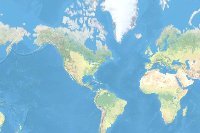

In [3]:
training_data = gis.content.get('ea94e88b5a56412995fd1ffcb85d60e9')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
DATA_ROOT = Path(os.path.join(filepath.split('.')[0]))

In [7]:
data = prepare_textdata(path=DATA_ROOT, batch_size=16, task='sequence_translation', 
                        text_columns='non-std-address', label_columns='std-address', 
                        train_file='address_standardization_correction.csv')

The `show_batch()` method can be used to see the training samples, along with labels.

In [8]:
data.show_batch()

non-std-address,std-address
"515, 4th st ne, mason city, ia, 50401, us","515, 4th st ne, mason city, ia, 50401, us"
"2150, 4th avenue south, clear lake, iowa, 50420, us","2150, 4th ave s, clear lake, ia, 50420, us"
"531, 12th ave n, clear lak, ia, 50428, us","531, 12th ave n, clear lake, ia, 50428, us"
"428, 29th srteet south west, mason city, iowa, 50401, us","428, 29th st sw, mason city, ia, 50401, us"
"522, n pennsylvania vae, mason city, ia, 50401, us","522, n pennsylvania ave, mason city, ia, 50401, us"


# SequenceToSequence model

`SequenceToSequence` model in `arcgis.learn.text` is built on top of [Hugging Face Transformers](https://huggingface.co/transformers/v3.0.2/index.html) library. The model training and inferencing workflows are similar to computer vision models in `arcgis.learn`. 

Run the command below to see what backbones are supported for the sequence translation task.

In [9]:
SequenceToSequence.supported_backbones

['T5', 'Bart', 'Marian']

Call the model's `available_backbone_models()` method with the backbone name to get the available models for that backbone. The call to **available_backbone_models** method will list out only a few of the available models for each backbone. Visit [this](https://huggingface.co/transformers/pretrained_models.html) link to get a complete list of models for each backbone.

In [10]:
SequenceToSequence.available_backbone_models("T5")


['t5-small', 't5-base', 't5-large', 't5-3b', 't5-11b', 'See all T5 models at https://huggingface.co/models?filter=t5 ']


## Load model architecture

Invoke the `SequenceToSequence` class by passing the data and the backbone you have chosen. The dataset consists of house addresses in non-standard format with synthetic errors, we will finetune a [t5-base](https://huggingface.co/t5-base) pretrained model. The model will attempt to learn how to standardize and correct the input addresses.

In [11]:
model = SequenceToSequence(data,backbone='t5-base')

## Model training

The `learning rate`[[1]](#References) is a **tuning parameter** that determines the step size at each iteration while moving toward a minimum of a loss function, it represents the speed at which a machine learning model **"learns"**. `arcgis.learn` includes a learning rate finder, and is accessible through the model's `lr_find()` method, which can automatically select an **optimum learning rate**, without requiring repeated experiments.

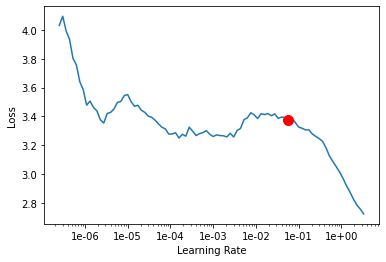

0.05754399373371566

In [12]:
model.lr_find()

Training the model is an iterative process. We can train the model using its `fit()` method till the validation loss (or error rate) continues to go down with each training pass also known as epoch. This is indicative of the model learning the task.

In [13]:
model.fit(1, 0.06)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,0.650808,0.432229,0.943515,0.878214,1:07:27


By default, the earlier layers of the model (i.e. the backbone) are frozen. Once the later layers have been sufficiently trained, the earlier layers are unfrozen (by calling `unfreeze()` method of the class) to further fine-tune the model.

In [14]:
model.unfreeze()

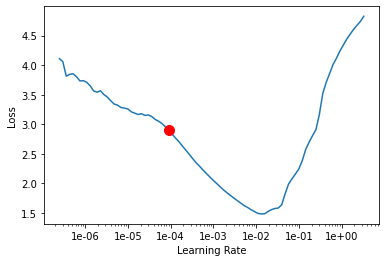

In [15]:
lr = model.lr_find()

In [16]:
model.fit(5, lr)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,0.028212,0.022333,0.995176,0.987848,1:47:10
1,0.017348,0.013526,0.997036,0.992545,1:48:46
2,0.013355,0.010491,0.997711,0.994252,1:49:02
3,0.008351,0.009511,0.998025,0.995039,1:49:16
4,0.006574,0.009464,0.998092,0.995216,1:49:16


## Validate results

Once we have the trained model, we can see the results to see how it performs.

In [17]:
model.show_results()

text,target,pred
"940, north pennsylvania avneue, mason icty, iowa, 50401, us","940, n pennsylvania ave, mason city, ia, 50401, us","940, n pennsylvania ave, mason city, ia, 50401, us"
"24640, a-b 305th srreet, nora speings, iowa, 50458, us","24640, a-b 305th st, nora springs, ia, 50458, us","24640, a-b 305th st, nora springs, ia, 50458, us"
"220, soyth rhodeisland aveune, mason city, iowa, 50401, us","220, s rhode island ave, mason city, ia, 50401, us","220, s rhode island ave, mason city, ia, 50401, us"
"2920, 1st srteet south west, mason ciry, iowa, 50401, us","2920, 1st st sw, mason city, ia, 50401, us","2920, 1st st sw, mason city, ia, 50401, us"
"210, s rhode island ave, mason ctiy, ia, 50401, us","210, s rhode island ave, mason city, ia, 50401, us","210, s rhode island ave, mason city, ia, 50401, us"


## Model metrics

To get a sense of how well the model is trained, we will calculate some important metrics for our `SequenceToSequence` model. To see what's the model accuracy[[2]](#References) and bleu score[[3]](#References) on the validation data-set. We will call the model's `get_model_metrics()` method.

In [18]:
m.get_model_metrics()

{'seq2seq_acc': 0.9981, 'bleu': 0.9952}

## Saving the trained model

Once you are satisfied with the model, you can save it using the save() method. This creates an Esri Model Definition (EMD file) that can be used for inferencing unseen data.

In [19]:
m.save('seq2seq_unfrozen_5E_bleu_99')

# Model inference

The trained model can be used to translate new text documents using the predict method. This method accepts a string or a list of strings to predict the labels of these new documents/text.

In [20]:
txt=['940, north pennsylvania avneue, mason icty, iowa, 50401, us',
     '220, soyth rhodeisland aveune, mason city, iowa, 50401, us',
    '427, n massachudetts ave, mason coty, ia, 50401, us']

In [21]:
model.predict(txt, num_beams=6, max_length=50)

[('940, north pennsylvania avneue, mason icty, iowa, 50401, us',
  '940, n pennsylvania ave, mason city, ia, 50401, us'),
 ('220, soyth rhodeisland aveune, mason city, iowa, 50401, us',
  '220, s rhode island ave, mason city, ia, 50401, us'),
 ('427, n massachudetts ave, mason coty, ia, 50401, us',
  '427, n massachusetts ave, mason city, ia, 50401, us')]

# Conclusion

In this notebook we will build an address standardization and correction model using `SequenceToSequence` class of `arcgis.learn.text` module. The dataset consisted of a pair of non-standard, incorrect (synthetic errors) house addresses and corresponding correct, standard house addresses from the United States. To achieve this we used a [t5-base](https://huggingface.co/t5-base) pretrained transformer to build a SequenceToSequence model to standardize and correct the input house addresses. Below are the results on sample inputs.

<span style="background-color: LightSalmon">Non-Standard</span> &rarr;  <span style="background-color: LightGreen">Standard
</span>  ,  <span style="background-color: LightCoral">Error</span> &rarr; <span style="background-color: LightGreen">Correction
</span>
* <span style="font-size:1.5em;">940, <span style="background-color: LightSalmon;">north</span> pennsylvania <span style="background-color: LightSalmon">avneue</span>, mason <span style="background-color: LightCoral">icty</span>, <span style="background-color: LightSalmon">iowa</span>, 50401, us &rarr; 940, <span style="background-color: LightGreen">n</span> pennsylvania <span style="background-color: LightGreen">ave</span>, mason <span style="background-color: LightGreen">city</span>, <span style="background-color: LightGreen">ia</span>, 50401, us</span>


* <span style="font-size:1.5em;">220, <span style="background-color: LightCoral">soyth rhodeisland</span> <span style="background-color: LightSalmon">aveune</span>, mason city, <span style="background-color: LightSalmon">iowa</span>, 50401, us &rarr; 220, <span style="background-color: LightGreen">s rhode island ave</span>, mason city, <span style="background-color: LightGreen">ia</span>, 50401, us</span>


* <span style="font-size:1.5em;">427, n <span style="background-color: LightCoral">massachudetts</span> ave, mason <span style="background-color: LightCoral">coty</span>, ia, 50401, us &rarr; 427, n <span style="background-color: LightGreen">massachusetts</span> ave, mason <span style="background-color: LightGreen">city</span>, ia, 50401, us</span>

# References

[1] [Learning Rate](https://en.wikipedia.org/wiki/Learning_rate)

[2] [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)

[3] [Bleu score](https://en.wikipedia.org/wiki/BLEU)